Following tutorial from SHAP library: https://shap.readthedocs.io/en/latest/index.html 

In [5]:
!pip install shap

     |████████████████████████████████| 564 kB 7.2 MB/s 


# (1) Boston dataset

Below we train a linear regression model on the classic boston housing dataset. This dataset consists of 506 neighboorhood regions around Boston in 1978, where our goal is to predict the median home price (in thousands) in each neighboorhood from 14 different features:

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000’s

In [3]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

LinearRegression()

## Examining the model coefficients

In [4]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

CRIM = -0.108
ZN = 0.0464
INDUS = 0.0206
CHAS = 2.6867
NOX = -17.7666
RM = 3.8099
AGE = 0.0007
DIS = -1.4756
RAD = 0.306
TAX = -0.0123
PTRATIO = -0.9527
B = 0.0093
LSTAT = -0.5248


## A more complete picture using partial dependence plots

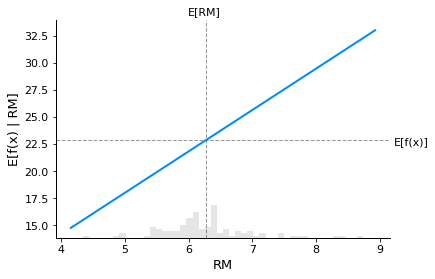

In [5]:
shap.plots.partial_dependence(
    "RM", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

The gray horizontal line in the plot above represents the expected value of the model when applied to the boston housing dataset. The vertical gray line represents the average value of the RM feature. Note that the blue partial dependence plot line (which the is average value of the model output when we fix the RM feature to a given value) always passes through the interesection of the two gray expected value lines.

## Reading SHAP values from partial dependence plots

Permutation explainer: 507it [00:43,  9.30it/s]                         


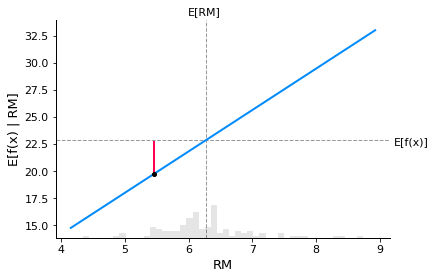

In [6]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "RM", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

/!\ Q: How do we know from which value of the X-axis we compute the difference with the gray horizontal line?

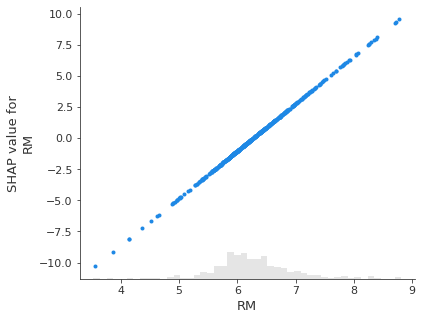

In [7]:
shap.plots.scatter(shap_values[:,"RM"])

## The additive nature of Shapley values

SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

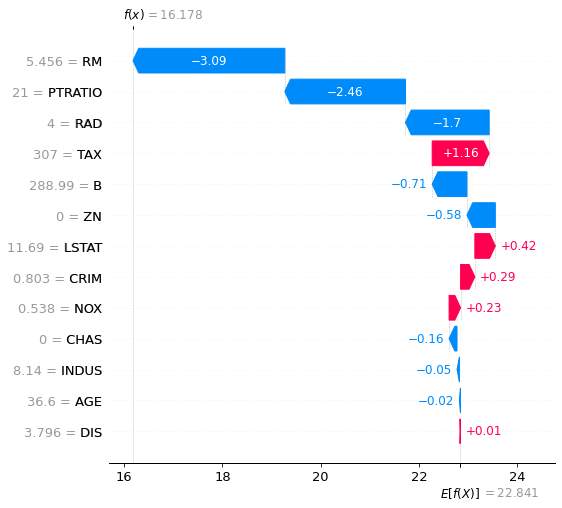

In [8]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

##  Explaining an additive regression model

The reason the partial dependence plots of linear models have such a close connection to SHAP values is because **each feature in the model is handled independently of every other feature (the effects are just added together)**. 

In [10]:
!pip install interpret

     |████████████████████████████████| 6.6 MB 5.2 MB/s 
     |████████████████████████████████| 5.8 MB 42.8 MB/s 
     |████████████████████████████████| 3.6 MB 56.3 MB/s 
     |████████████████████████████████| 9.6 MB 40.2 MB/s 
     |████████████████████████████████| 756 kB 50.6 MB/s 
     |████████████████████████████████| 275 kB 50.6 MB/s 
     |████████████████████████████████| 280 kB 47.2 MB/s 
     |████████████████████████████████| 131 kB 62.5 MB/s 
     |████████████████████████████████| 793 kB 52.7 MB/s 
     |████████████████████████████████| 251 kB 49.4 MB/s 
     |████████████████████████████████| 428 kB 42.3 MB/s 
     |████████████████████████████████| 130 kB 68.2 MB/s 
     |████████████████████████████████| 381 kB 64.1 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 357 kB 75.3 MB/s 
     |████████████████████████████████| 65 kB 2.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 

Permutation explainer: 507it [01:18,  5.76it/s]


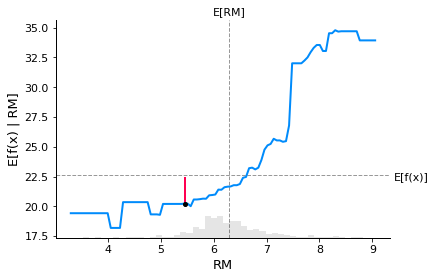

In [11]:
# fit a GAM model to the data
import interpret.glassbox # Glassbox vs backbox!! Seems to be a nice library!
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_ebm.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

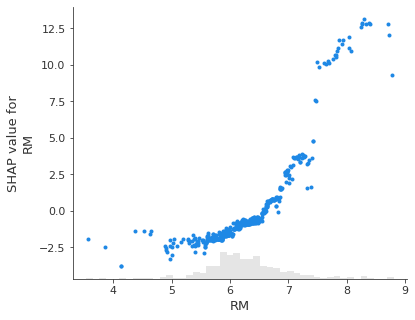

In [12]:
shap.plots.scatter(shap_values_ebm[:,"RM"])

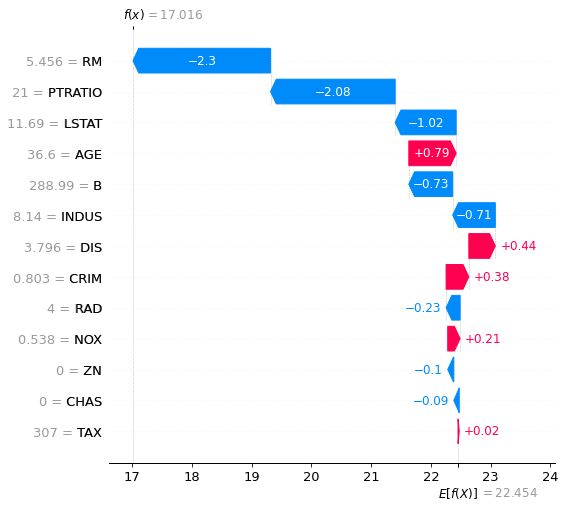

In [13]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind], max_display=14)

If we are willing to deal with a bit more complexity we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

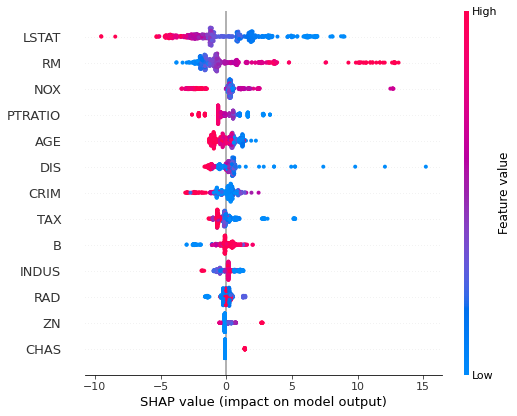

In [14]:
# interesting here: we do not need to select a specify instance!
shap.plots.beeswarm(shap_values_ebm, max_display=14)

## Explaining a non-additive boosted tree model

[13:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


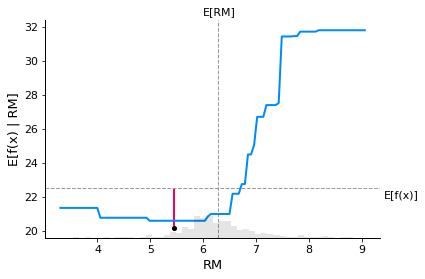

In [15]:
# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_xgb.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

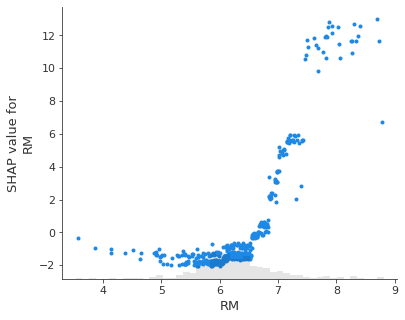

In [16]:
shap.plots.scatter(shap_values_xgb[:,"RM"])

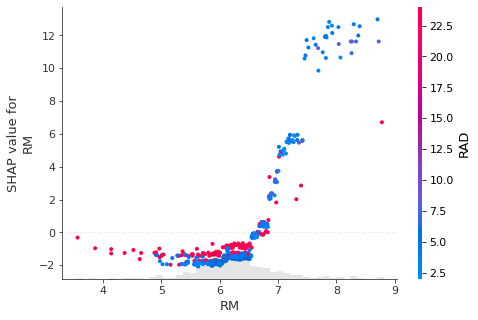

In [17]:
shap.plots.scatter(shap_values_xgb[:,"RM"], color=shap_values)

# (2) Adult census price dataset

## Explaining a linear logistic regression model

In [18]:
# a classic adult census dataset price dataset
X_adult,y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
    return model_adult.predict_proba(x)[:,1]
def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:,1] - p[:,0]

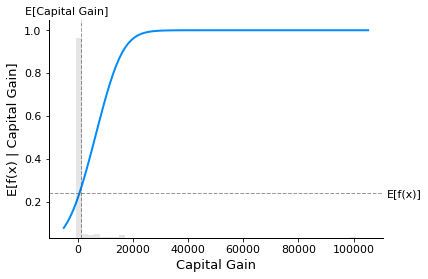

In [19]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

In [20]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])

Permutation explainer: 1001it [01:30,  9.82it/s]                          


## Explaining a non-additive boosted tree logistic regression model

In [21]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_adult, y_adult)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

 95%|=================== | 31048/32561 [00:23<00:01]       

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

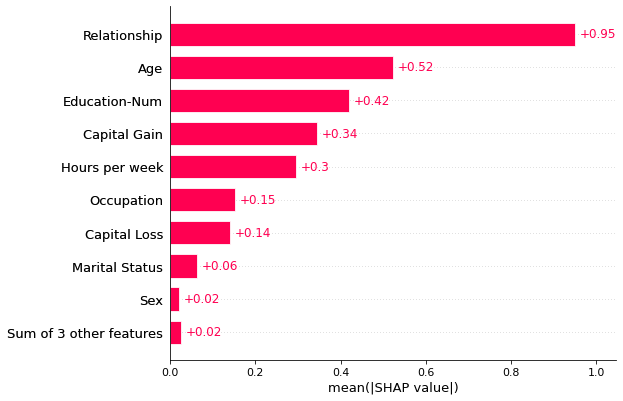

In [22]:
shap.plots.bar(shap_values)

But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrequent but high magnitude effects.

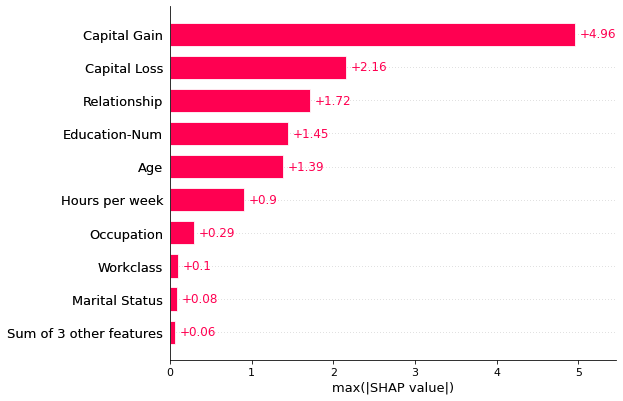

In [23]:
shap.plots.bar(shap_values.abs.max(0))

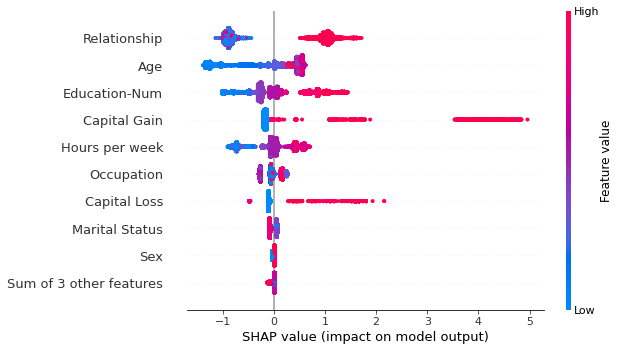

In [24]:
shap.plots.beeswarm(shap_values)

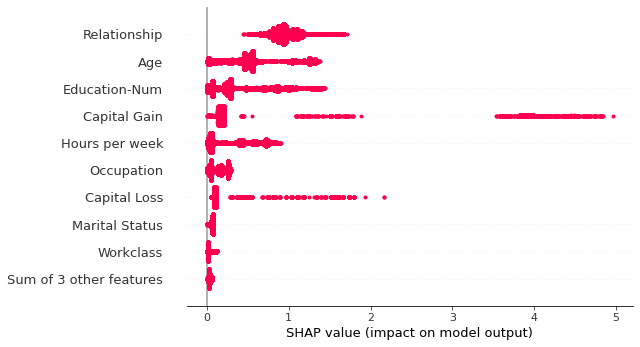

In [25]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

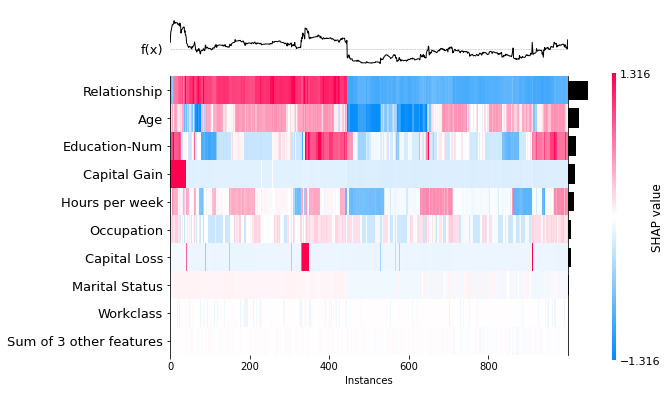

In [26]:
shap.plots.heatmap(shap_values[:1000])

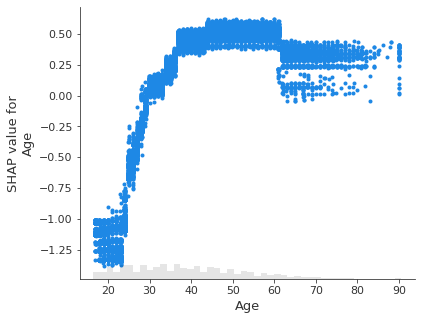

In [27]:
shap.plots.scatter(shap_values[:,"Age"])

## Dealing with correlated features

In [28]:
clustering = shap.utils.hclust(X_adult, y_adult)

[13:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 50%|█████     | 6/12 [00:00<?, ?it/s]

[13:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 67%|██████▋   | 8/12 [00:15<00:05,  1.50s/it]

[13:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 75%|███████▌  | 9/12 [00:18<00:07,  2.35s/it]

[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 83%|████████▎ | 10/12 [00:19<00:03,  1.78s/it]

[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 92%|█████████▏| 11/12 [00:20<00:01,  1.43s/it]

[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 12/12 [00:22<00:00,  1.51s/it]

[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

13it [00:23,  3.38s/it]

[13:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


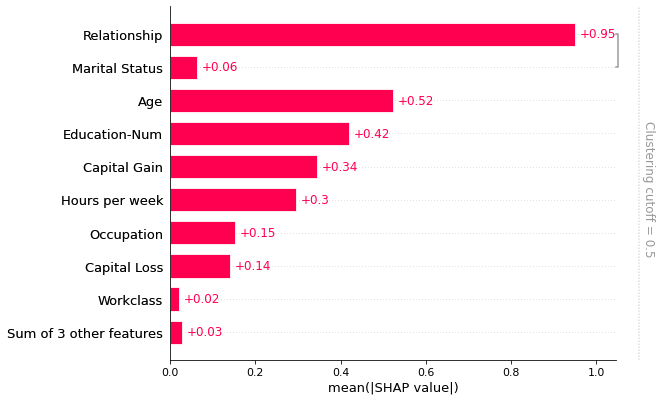

In [29]:
shap.plots.bar(shap_values, clustering=clustering)

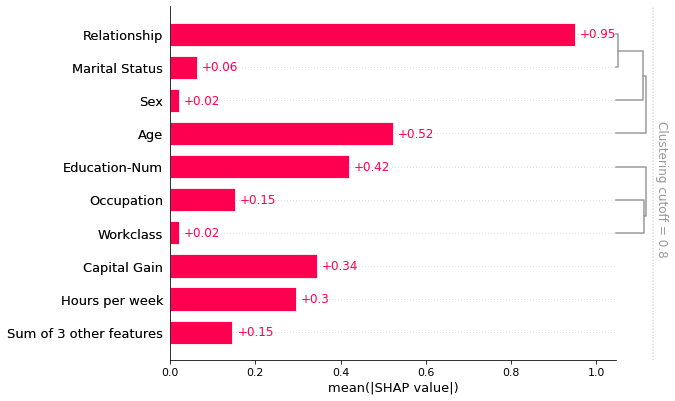

In [30]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

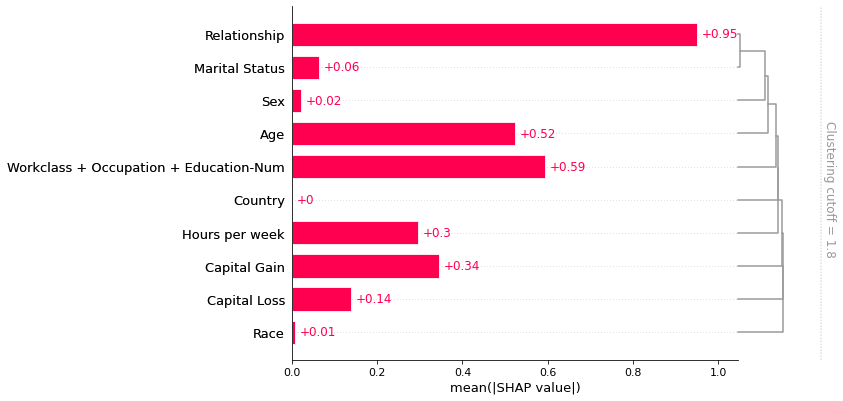

In [31]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)

# (3) IMDB reviews

## Explaining a transformers NLP model
This demonstrates how SHAP can be applied to complex model types with highly structured inputs.

In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 8.6 MB/s 
     |████████████████████████████████| 895 kB 52.0 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 
     |████████████████████████████████| 596 kB 56.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 9.2 MB/s 
     |████████████████████████████████| 212 kB 62.3 MB/s 


In [6]:
import transformers
import nlp
import torch
import numpy as np
import scipy as sp

# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10], fixed_context=1)

NameError: ignored

In [ ]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))